# Project 4 - Black Jack {-}
## Sam Linderoth {-}


## Introduction {-}

In this project, we consider the game of [blackjack](https://en.wikipedia.org/wiki/Blackjack). Our aim is to train a reinforcement learning agent to play the game optimally, using [Q-learning](https://en.wikipedia.org/wiki/Q-learning).

## The Sutton and Barto Setup {-}

We begin by setting up the game in a similar fashion as in Sutton and Barto (p. 93), which the authors describe in the following fashion:

"The object of the popular casino card game of blackjack is to obtain cards the sum of whose numerical values is as great as possible without exceeding 21. All face cards count as 10, and an ace can count either as 1 or as 11. We consider the version in which each player competes independently against the dealer. The game begins with two cards dealt to both dealer and player. One of the dealer’s cards is face up and the other is face down. If the player has 21 immediately (an ace and a 10-card), it is called a natural. He then wins unless the dealer also has a natural, in which case the game is a draw. If the player does not have a natural, then he can request additional cards, one by one (hits), until he either stops (sticks) or exceeds 21 (goes bust). If he goes bust, he loses; if he sticks, then it becomes the dealer’s turn. The dealer hits or sticks according to a fixed strategy without choice: he sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome — win, lose, or draw — is determined by whose final sum is closer to 21.

Playing blackjack is naturally formulated as an episodic finite MDP. Each game of blackjack is an episode. Rewards of +1, -1, and 0 are given for winning, losing, and drawing, respectively. All rewards within a game are zero, and we do not discount ($\gamma = 1$); therefore these terminal rewards are also the returns. The player’s actions are to hit or to stick. The states depend on the player’s cards and the dealer’s showing card. We assume that cards are dealt from an infinite deck (i.e., with replacement) so that there is no advantage to keeping track of the cards already dealt. If the player holds an ace that he could count as 11 without going bust, then the ace is said to be usable. In this case it is always counted as 11 because counting it as 1 would make the sum 11 or less, in which case there is no decision to be made because, obviously, the player should always hit. Thus, the player makes decisions on the basis of three variables: his current sum (12–21), the dealer’s one showing card (ace–10), and whether or not he holds a usable ace. This makes for a total of 200 states."

Unlike Sutton and Barto, who solve the problem using Monte Carlo prediction methods, we are going to attack the game with Q-learning. There are no specific reasons for this choice of method, other than that we are interested in learning more about the approach.

The Sutton and Barto setup of blackjack is a simplified version of the game; it does not allow for actions like doubling or insurance. This specific environment is actually available in the **gymnasium** library for Python, and a full implementation is readily available in the [documentation](https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/).

We will begin by copying this whole basic implementation and try it out, using a decaying epsilon rate, a learning rate $\alpha$ of 0.001, no discounting $(\gamma = 1)$, and one million episodes.

In the next section, we will build our own environment and implement more features to the game, and compare the results to the ones we achieve in this section.

In [2]:
# Author: Till Zemann
# License: MIT License
# The code in this block is largely taken from:
# https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/

from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import gymnasium as gym



env = gym.make("Blackjack-v1", sab = True)

done = False
observation, info = env.reset()

class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 1,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

# hyperparameters
learning_rate = 0.001
n_episodes = 1_000_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()
    
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    
    if not usable_ace:
        x_lim = 8
    else:
        x_lim = 11
    
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(x_lim + 1, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    
    
    nrow = value.shape[1]
    value_firstrow = [value[0, ]]
    value_rest = value[1:, ]
    value = np.concatenate((value_rest, value_firstrow), axis=0)
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    
    polgrid_firstrow = [policy_grid[0]]
    polgrid_rest = policy_grid[1:, ]
    policy_grid = np.concatenate((polgrid_rest, polgrid_firstrow), axis=0)
    
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid,  title: str, usable_ace = False):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)
    
    if not usable_ace:
        x_lim = 8
    else:
        x_lim = 11

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="cool",
        edgecolor="none",
    )
    plt.xticks(range(x_lim + 1, 22), range(x_lim + 1, 22))
    plt.yticks(range(1, 11), list(range(2, 11)) + ["A"])
    ax1.set_title(f"State values")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(x_lim + 1, 22))
    ax2.set_yticklabels(list(range(2, 11)) + ["A"], fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


100%|███████████████████████████████| 1000000/1000000 [02:33<00:00, 6528.31it/s]


#### Figure 1: State values and policies, n = 10^6 iterations {-}

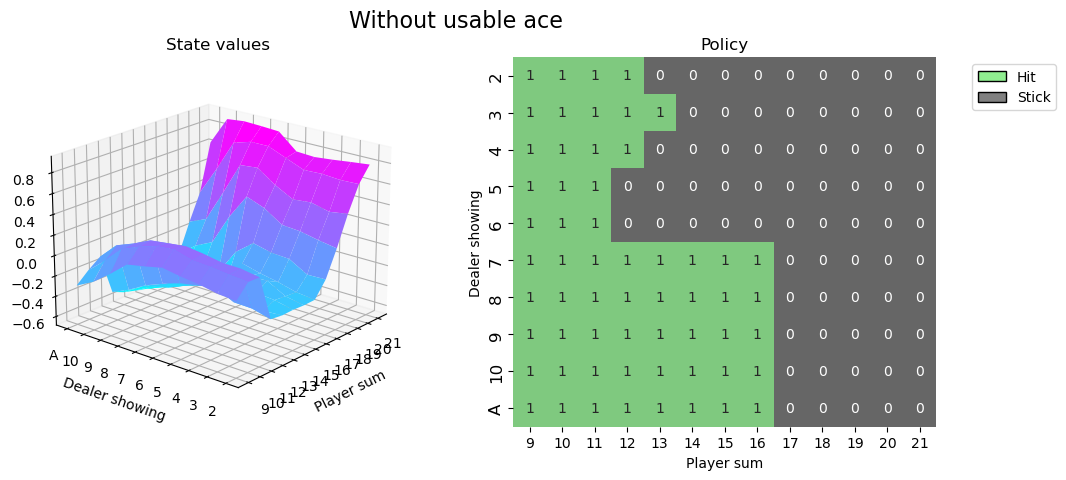

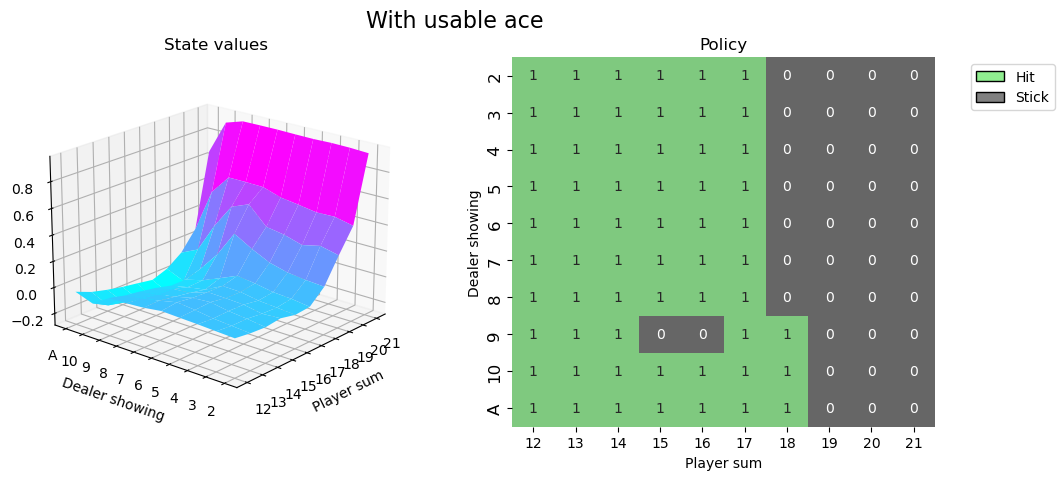

In [3]:
value_grid, policy_grid = create_grids(agent, usable_ace = False)
fig2 = create_plots(value_grid, policy_grid, usable_ace = False, title="Without usable ace")
plt.show()

value_grid, policy_grid = create_grids(agent, usable_ace = True)
fig1 = create_plots(value_grid, policy_grid, usable_ace = True, title="With usable ace")
plt.show()

The results are similar to the usual [blackjack strategy tables](https://www.blackjackapprenticeship.com/blackjack-strategy-charts/) that one might find, with some exceptions. Obviously, the tables achieved here also lack options like doubling, splitting and other actions.

Having completed this simplified setup, we now proceed to construct a more versatile and realistic setting of the game and compare the resulting state values and policies with the ones in Figure 1.

## Beyond Sutton and Barto {-}

In this section, we consider following game setting:

A player places a bet (default = 1) at the game table. The player is then dealt two open cards, and the dealer is dealt one open card ("up card") and one hidden card ("hole card").

If the two first cards dealt to the player results in a "natural" blackjack at value 21 (for example, an ace and a king), the reward is 1.5 times the bet – unless the dealer also has a blackjack, in which case the game is considered a tie.

Otherwise, the player is faced with the following choices:
* stick, in which case no more cards are dealt to the player and the turn goes to the dealer
* hit, where one more card is dealt to the player. This action may be repeated
* double, where the bet is doubled down and only one more card is dealt to the player. This can only be done at the very first round, with no other restrictions implemented
* insure, which can only be done at the first round if the dealer up card is an ace. If the dealer turns out to hold a natural blackjack, the game is considered a tie and the bet plus insurance cost is returned to the player. Otherwise, the game continues. The cost of insurance is half of the player's bet.

In reality, many blackjack tables also offer the possibility of a *split* when two cards of the same value are dealt to the player. In such cases, the cards are split into two different hands. However, for simplicity and to ease plotting somewhat, we will not consider splits in this project.

Rather than using, as in the former section, an infinite deck of cards, we instead have a limited *shoe* consisting of one or more decks. The shoe is not shuffled between rounds, but reset (and shuffled) when reaching a "cut card" which is set at a random place within the shoe. As a default, we will use only one deck during training to ease the computations. The optimal policy derived during training on one deck will then be applied to larger shoes in a "live" playing setting.

From a modelling perspective, the situation and MDP is still quite reminiscent to that of the former section. The most notable difference is that the agent has more actions to choose between, leading to larger state-action space.

Again, we use a learning rate $\alpha$ of 0.001, no discounting with $\gamma = 1$, and a decaying epsilon rate during training.

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import random
from datetime import datetime

def set_up_storage(count_limit = 20):
    
    '''
    A function to set up dicts to store Q values
    '''
    
    # Base dict for actions
    action_dict = {"stick": 0,
                 "hit" : 0,
                 "double": 0,
                 "insure": 0}
    
    # Base dict for terminal state
    terminal_dict = {"win": 0,
              "tie": 0,
              "loss": 0,
              "insurance loss" : 0}
    
    # Set up Q with no usable ace "NUA"
    Q = {((i, "NUA"), j) : {l : action_dict.copy()
        for l in range(-count_limit, count_limit + 1)} 
        for i in range(4, 22) 
        for j in range(2, 12)}
    
    # Set up Q with usable ace "UA"
    Q.update({((i, "UA"), j) : {l : action_dict.copy()
        for l in range(-count_limit, count_limit + 1)} 
        for i in range(4, 22) 
        for j in range(2, 12)})
    
    # Add terminal states to Q
    Q.update({terminal_state : {"stop": 0} 
              for terminal_state in terminal_dict.keys()})
    
    return(Q)


class Shoe:
    
    '''
    A class object to hold a number of decks (default = 1) in a shoe
    '''
    
    def __init__(self, num_decks = 1, thorp = False, count_limit = 20):
        self.num_decks = num_decks
        self.cards = self._create_shoe()
        self.cc = CardCounter(count_limit)
        self.thorp = thorp
        self.count_limit = count_limit

    def _create_shoe(self):
        
        '''
        Set up a shuffled shoe with num_decks of cards and a cut card.
        Ace cards: 1
        J, D, K cards: 10
        '''
        
        # One card suite
        cards = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        
        # Full shoe
        shoe = int(self.num_decks*4)*cards + ["cut"]

        # Shuffle
        random.shuffle(shoe)
        
        return shoe

    def draw_card(self, hole = False):
        
        '''
        Draw and return card from the shoe, update counter via CardCounter.
        If cut card is drawn, the shoe is reset.
        '''
        
        card = self.cards.pop(0)
        
        if card == "cut":
            self.reset_shoe()
            card = self.draw_card()  # Draw again after reset
        else:
            if not hole: # Count only non-hole cards
                self.cc.update_count(card, max(len(self.cards)-1, 1), 
                                     self.num_decks, thorp = self.thorp)
        
        return card
    
    def update_cc_hole(self, card):
        
        '''
        Add hole card to count after displaying.
        '''
        
        self.cc.update_count(card, max(len(self.cards)-1, 1), 
                             self.num_decks, thorp = self.thorp)


    def reset_shoe(self):
        '''
        Reset the shoe and card counter.
        '''
        self.cards = self._create_shoe()
        self.cc.reset_count()
        

class CardCounter:
    
    '''
    A class object to count cards
    '''
    
    def __init__(self, count_limit = 20):
        self.running_count = 0
        self.ace_count = 0
        self.count = 0
        self.bet = 1
        self.count_limit = count_limit

    def update_count(self, card, num_cards, num_decks, thorp = False):
        
        '''
        Method to update card count if it's activated.
        Count/bet method according to: 
        edwardothorp.com/wp-content/uploads/2016/11/CountingEveryCardInTheDeck.pdf
        '''
        
        if thorp:
              
            if card in [10]:
                self.running_count -= 1
            elif card in [3, 4, 5, 6]:
                self.running_count += 1
            if card == 1:
                self.ace_count += 1
                
            # Set the "true" count, limit count states for parsimonity
            self.count = round(52*self.running_count/num_cards, 0)
            if self.count < -self.count_limit:
                self.count = -self.count_limit
            elif self.count > self.count_limit:
                self.count = self.count_limit

            # Set the bet, limit bet states for parsimonity
            self.bet = self.count + ((num_decks*4 - self.ace_count)/num_cards - 1/13)*64
            self.bet = max(round(self.bet, 0), 1)
            
        if not thorp:
            # Set default values if not counting
            self.bet = 1
            self.count = 0
        
    def reset_count(self):
        '''
        Reset the counts.
        '''
        self.running_count = 0
        self.ace_count = 0
        self.count = 0
        self.bet = 1

def usable_ace(hand):
    '''
    A function to check if hand contains usable ace. 
    Taken from github.com/rianrajagede/reinforcement-learning/blob/master/BlackJack_TD.py        
    '''
    return 1 in hand and sum(hand) + 10 <= 21

def get_value(hand):
    
    '''
    A function to get the value of a hand.
    Inspired from github.com/rianrajagede/reinforcement-learning/blob/master/BlackJack_TD.py        
    '''
    
    if usable_ace(hand):
        return (sum(hand) + 10, "UA")
    else:
        return (sum(hand), "NUA")

def choose_action(Q, hand_state, shoe, turn_counter, eps = 0.1):
    
    '''
    A function to choose actions.
    '''
    
    # Make copy of state
    Qstate_copy = Q[hand_state][shoe.cc.count].copy()
    
    # Remove insurance/double if game is beyond first hand
    if turn_counter > 0:
        if "insure" in Qstate_copy.keys():
            Qstate_copy.pop("insure")
        if "double" in Qstate_copy.keys():
            Qstate_copy.pop("double")
    
    # Remove insurance if dealer hand is not ace
    if hand_state[1] != 11 and "insure" in Qstate_copy.keys():
        Qstate_copy.pop("insure")
    
    # Get actions/max action
    actions = list(Qstate_copy.keys())
    max_action = max(Qstate_copy, key = Qstate_copy.get)

    if random.uniform(0, 1) <= eps:
        return(random.choice(actions)) # Return exploring action
    else:
        return(max_action) # Return greedy action


def take_action(p_ha, p_v, d_ha, d_v, action, shoe, hand_state, bet, turn_counter):
    
    '''
    A function to take actions, get returns etc.
    '''
    
    dealer_fullval = get_value(d_ha)
    
    # If dealer has natural
    if turn_counter == 0 and dealer_fullval[0] == 21 and action != "insure":
        ret = -bet
        new_handstate = "loss"
        return(p_ha, p_v, d_ha, new_handstate, ret)
    
    if action == "insure":
        
        if dealer_fullval[0] == 21:
            ret = 0
            new_handstate = ("tie")
        else:
            ret = -bet/2
            new_handstate = hand_state
        
        return(p_ha, p_v, d_ha, new_handstate, ret)
    
    if action == "double":
        p_ha += [shoe.draw_card()] # Draw one more card
        p_v = get_value(p_ha) # Fetch value
        
        if p_v[0] > 21: # Bust
            ret = -2*bet
            new_handstate = ("loss")
            return(p_ha, p_v, d_ha, new_handstate, ret)
        else:
            return(take_action(p_ha, p_v, d_ha, d_v, "stick", shoe, hand_state, 2*bet, turn_counter))
    
    if action == "hit":
        p_ha += [shoe.draw_card()]
        p_v = get_value(p_ha)
        
        if p_v[0] > 21: # Bust
            ret = -bet
            new_handstate = ("loss")
        else:
            ret = 0
            new_handstate = (p_v, d_v[0])
        
        return(p_ha, p_v, d_ha, new_handstate, ret)
    
    # Dealer's turn
    if action == "stick":
        d_v = get_value(d_ha)
        
        # Dealer draws while below or equal to 16
        while d_v[0] <= 16:
            d_ha += [shoe.draw_card()]
            d_v = get_value(d_ha)

        if d_v[0] > 21 or (d_v[0] < p_v[0]):
            new_handstate = ("win")
            ret = bet

        elif d_v[0] == p_v[0]:
            new_handstate = ("tie")
            ret = 0

        elif d_v[0] <= 21 and (d_v[0] > p_v[0]):
            new_handstate = ("loss")
            ret = -bet
            
        return(p_ha, p_v, d_ha, new_handstate, ret)
    

def get_maxvalue(Q, shoe, new_handstate):
    
    '''
    A function to get max value from (next) state.
    '''
    
    if new_handstate in ["tie", "loss", "win"]:
        return 0
    else:
        Q_newstate_copy = Q[new_handstate][shoe.cc.count].copy()
        
        # Remove double, insure as function is only called after first turn
        if "double" in Q_newstate_copy.keys():
            Q_newstate_copy.pop("double")
        if "insure" in Q_newstate_copy.keys():
            Q_newstate_copy.pop("insure")

        max_action = max(Q_newstate_copy, key = Q_newstate_copy.get)
        max_value = Q_newstate_copy[max_action]
        
        return max_value

    
def init_episode(shoe):
    
    '''
    A function to initialize an episode
    '''
    
    # Initialize player hand
    p_ha = [shoe.draw_card(), shoe.draw_card()]
    p_v = get_value(p_ha)
    
    # Initialize dealer hand, hole = hidden, open = showing
    d_hole = [shoe.draw_card(hole = True)]
    d_open = [shoe.draw_card()]
    d_ha = d_hole + d_open
    d_v = get_value(d_open)
    
    # Set hand state
    hand_state = (p_v, d_v[0])
    
    return(p_ha, p_v, d_ha, d_hole, d_open, d_v, hand_state)
    
    
def generate_q_episode(Q, shoe, results, rewards, 
                       thorp = False, train = True, ga = 1, al = 0.01, eps = 0.1):
    
    '''
    Generate an episode in Q-learning
    '''
    
    if thorp :
        base_bet = 1
        bet_factor = shoe.cc.bet
    else:
        base_bet = 1
        bet_factor = 1
    
    # Initialize episode
    p_ha, p_v, d_ha, d_hole, d_open, d_v, hand_state = init_episode(shoe)
    
    # If natural Blackjack
    if p_v[0] == 21:
        
        dealer_fullval = get_value(d_ha)
        
        if dealer_fullval[0] == 21:
            hand_state = ("tie")
            bet_factor = 0
        else:
            hand_state = ("win")
        
        ret = 1.5*base_bet*bet_factor # 1.5x bet for natural
        
        results[hand_state] += 1
        rewards[hand_state] += ret
        
        # Update card count when dealer hole has been shown
        shoe.update_cc_hole(d_hole[0])
        
        return(Q, results, rewards)
    
    # Counters
    reward_counter = 0
    turn_counter = 0
        
    # If not natural Blackjack
    while True:
        
        # Save base count before taking action
        base_count = shoe.cc.count
        
        # Choose action
        action = choose_action(Q, hand_state, shoe, turn_counter, eps = eps)
        
        # Take action, observe reward, new state etc.
        p_ha, p_v, d_ha, new_handstate, ret = take_action(p_ha, p_v, d_ha, d_v, 
                                                      action, shoe, hand_state, 
                                                          base_bet, turn_counter)
        
        # Update Q if training is active
        if train:
            
            # Get max value of new hand state
            newstate_maxvalue = get_maxvalue(Q, shoe, new_handstate)

            # Update Q
            Q[hand_state][base_count][action] += al*(ret + ga*newstate_maxvalue - 
                                                     Q[hand_state][base_count][action])
            
        hand_state = new_handstate # Update state
        reward_counter += ret
        turn_counter += 1
        
        # End episode
        if hand_state in [("loss"), ("tie"), ("win")]:
            
            # Save result
            results[hand_state] += 1
            
            # Add insurance cost
            if hand_state == "tie" and reward_counter != 0:
                hand_state = ("insurance loss")
            
            # Save reward
            rewards[hand_state] += bet_factor*reward_counter
            
            break
    
    # Update card count when dealer hole has been shown
    shoe.update_cc_hole(d_hole[0])
            
    return(Q, results, rewards)

def run_agent(Q, n_iter, thorp = False, 
              al = 0.001, train = False, n_decks = 1):
    
    '''
    A function to train the agent.
    '''
    
    # Set shoe
    shoe = Shoe(n_decks, thorp = thorp)
    
    # Counter
    iter_counter = 0
    
    # List for cumulative rewards
    cumul_rewards = []
    
    # Dict for results
    results = {"win": 0,
              "tie": 0,
              "loss": 0}


    # Dict for rewards rewards
    rewards = {"win": 0,
              "tie": 0,
              "loss": 0,
              "insurance loss" : 0}
    
    # List for cumulative rewards
    cumul_rewards = []
    
    # Training loop
    while iter_counter < n_iter:
        
        # Decaying epsilon if training, else only greedy action
        if train:
            eps = min((n_iter/3)/(iter_counter+1), 1)
        else:
            eps = 0
        
        # Generate episode
        Q, results, rewards = generate_q_episode(Q, shoe, results, rewards, thorp = thorp,
                                                        al = al, train = train, eps = eps)
        
        # Cumulative reward list for plotting
        cumul_rewards += [(rewards["win"] + rewards["loss"] + rewards["insurance loss"])]
        
        iter_counter += 1
    
    return(Q, results, rewards, cumul_rewards)

def create_grids(Q, usable_ace, count_key = 0):
    
    '''
    A function to create grids.
    Inspired from: gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/
    '''
    
    if usable_ace == "NUA":
        x_lim = 8
        no_cols = 13
    else:
        x_lim = 11
        no_cols = 10

    policy_grid = np.ndarray(shape=(10, no_cols))
    values = np.ndarray(shape=(10, no_cols))
    
    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(x_lim + 1, 22),
        np.arange(2, 12),
    )

    Q_copy = Q.copy()
    Q_copy.pop("tie")
    Q_copy.pop("win")
    Q_copy.pop("loss")
    Q_copy.pop("insurance loss")
    
    row = 0
    col = 0

    for key in Q_copy.keys():
        if key[0][0] > x_lim and key[0][1] == usable_ace:
            
            qkeycopy = Q_copy[key][count_key].copy()
            
            if key[1] != 11:
                qkeycopy.pop("insure")

            max_action = max(qkeycopy, key = qkeycopy.get)
            max_action_value = qkeycopy[max_action]
            
            values[row, col] = max_action_value

            if max_action == "stick":
                policy_grid[row, col] = 0

            if max_action == "hit":
                policy_grid[row, col] = 1

            if max_action == "double":
                policy_grid[row, col] = 2

            if max_action == "insure":
                policy_grid[row, col] = 3

            row += 1

            if key[1] == 11:
                col += 1
                row = 0
                
    value_grid = player_count, dealer_count, values
    
    return(value_grid, policy_grid)

def create_plots(policy_grid, value_grid, title: str):
    
    '''
    A function to create plots.
    Largely taken from: gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/
    '''
    
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)
    
    num_rows, num_cols = policy_grid.shape
    start_x = 22 - num_cols

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="cool",
        edgecolor="none",
    )
    plt.xticks(range(start_x, 22), range(start_x, 22))
    plt.yticks(range(1, 11), list(range(2, 11)) + ["A"] )
    ax1.set_title(f"State values")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)
    
    cmap = ListedColormap(["gray", "green", "yellow", "blue"])
    n = Normalize(vmin=0,vmax=3)
    
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap=cmap, cbar=False, norm=n)
    ax2.set_title(f"Policy")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(start_x, 22))
    ax2.set_yticklabels(list(range(2, 11)) + ["A"], fontsize=12)

  #   add a legend
    legend_elements = [
        Patch(facecolor="gray", edgecolor="black", label="Stick"),
        Patch(facecolor="green", edgecolor="black", label="Hit"),
        Patch(facecolor="yellow", edgecolor="black", label="Double"),
        Patch(facecolor="blue", edgecolor="black", label="Insure"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig

def wrapup(train_episodes, live_episodes = 1_000_000, 
           thorp = False, plot = False, al = 0.001, n_decks = 1):
    
    '''
    A wrap-up function to train, 
    get results, plots etc.
    '''
    
    # Set up storages
    Q = set_up_storage()

    # Train
    Q, results, rewards, cumul_rewards = run_agent(Q, train = True, thorp = thorp, 
                                                   n_iter = train_episodes, 
                                                   al = al, n_decks = n_decks)

    # Run live agent to get results/rewards from playing 
    # according to current optimal policy, n = 1 000 000 games
    Q, results, rewards, cumul_rewards = run_agent(Q, train = False, thorp = thorp, 
                                                     n_iter = live_episodes, al = 0, 
                                                     n_decks = n_decks)

    # Calculate results
    win_ratio = round(results["win"]/(results["win"] + results["loss"] + results["tie"]), 3)
    reward_ratio = round(rewards["win"]/abs(rewards["loss"] + rewards["insurance loss"]), 3)
    net_gain = int(rewards["win"] + (rewards["loss"] + rewards["insurance loss"]))
    
    # Get / don't get plots
    if not thorp and plot == True:
        noace_valgrid, noace_polgrid = create_grids(Q, "NUA")
        fig1 = create_plots(noace_polgrid, noace_valgrid, 
                            title = "Without usable ace")

        ace_valgrid, ace_polgrid = create_grids(Q, "UA")
        fig2 = create_plots(ace_polgrid, ace_valgrid, 
                            title = "With usable ace")
        
    if thorp or plot == False:
        fig1 = 0
        fig2 = 0
    
    return(Q, results, rewards, win_ratio, 
           reward_ratio, net_gain, cumul_rewards, fig1, fig2)

def test_on_largerdeck(Q, n_decks, n_iter = 1_000_000, thorp = False):
    
    '''
    A function to test the learned optimal policy, 
    derived from Q, on larger shoe sizes.
    '''

    Q, results, rewards, cumul_rewards = run_agent(Q, train = False, thorp = thorp, 
                                                   n_iter = n_iter, al = 0, n_decks = n_decks)

    win_ratio = round(results["win"]/(n_iter), 3)
    reward_ratio = round(rewards["win"]/abs(rewards["loss"] + rewards["insurance loss"]), 3)
    net_gain = int(rewards["win"] + (rewards["loss"] + rewards["insurance loss"]))
    
    return([n_decks, win_ratio, reward_ratio, net_gain])

We begin by plotting the state-value function and policy, having trained the agent for only 10 000 episodes.

$\pagebreak$

#### Figure 2: State values and policies, n = 10^4 iterations {-}

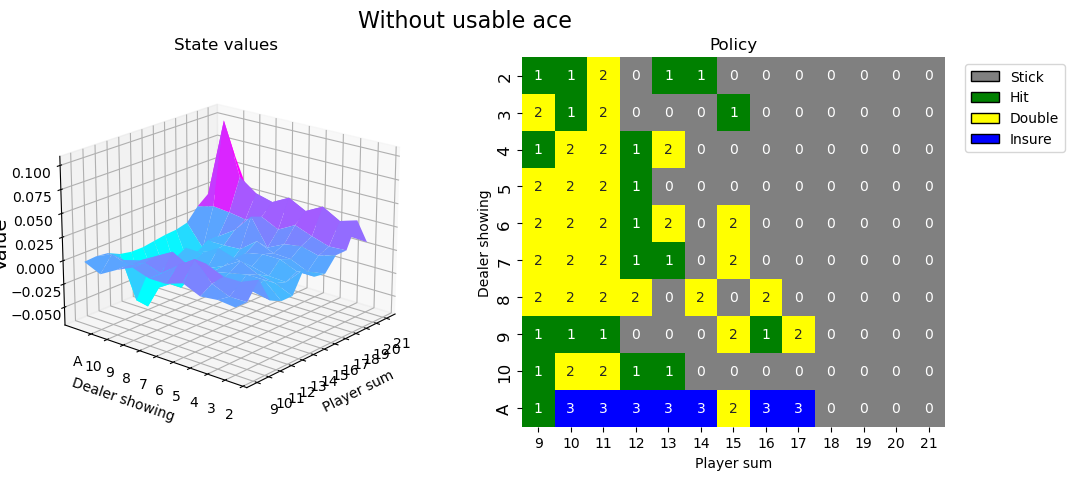

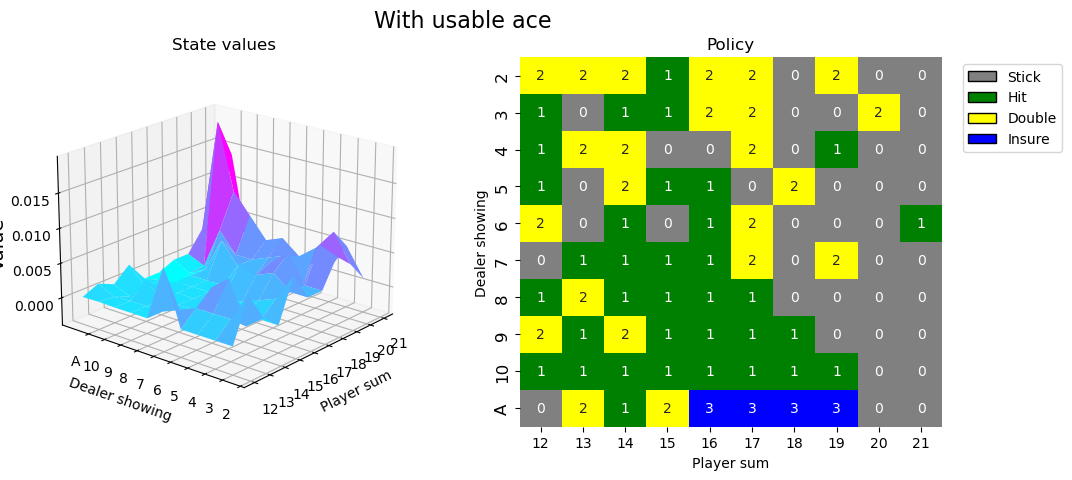

In [5]:
(Q_nt104, results_nt104, rewards_nt104, 
win_ratio_nt104, reward_ratio_nt104, 
net_gain_nt104, cumul_rewards_nt104, 
fig1_nt104, fig2_nt104) = wrapup(10**4, thorp = False, plot = True)

As can be seen in Figure 2, the state values and policy is quite messy at this point. We proceed to increase the training, and run the agent for 100 million episodes.

In [6]:
(Q_nt105, results_nt105, rewards_nt105, 
win_ratio_nt105, reward_ratio_nt105, 
net_gain_nt105, cumul_rewards_nt105, 
fig1_nt105, fig2_nt105) = wrapup(10**5, thorp = False, plot = False)

In [7]:
(Q_nt106, results_nt106, rewards_nt106, 
win_ratio_nt106, reward_ratio_nt106, 
net_gain_nt106, cumul_rewards_nt106, 
fig1_nt106, fig2_nt106) = wrapup(10**6, thorp = False, plot = False)

In [8]:
(Q_nt107, results_nt107, rewards_nt107, 
win_ratio_nt107, reward_ratio_nt107, 
net_gain_nt107, cumul_rewards_nt107, 
fig1_nt107, fig2_nt107) = wrapup(10**7, thorp = False, plot = False)

$\pagebreak$

#### Figure 3: State values and policies, n = 10^8 iterations {-}

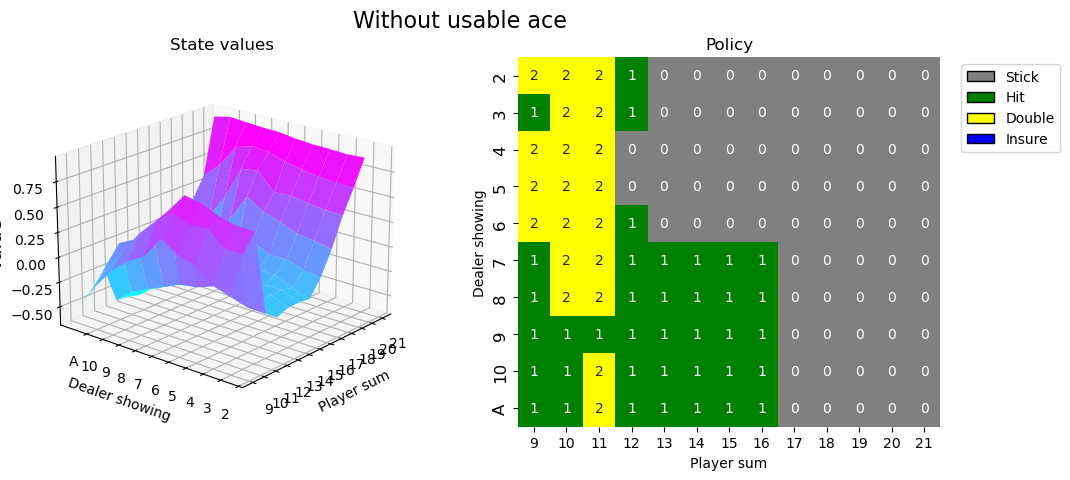

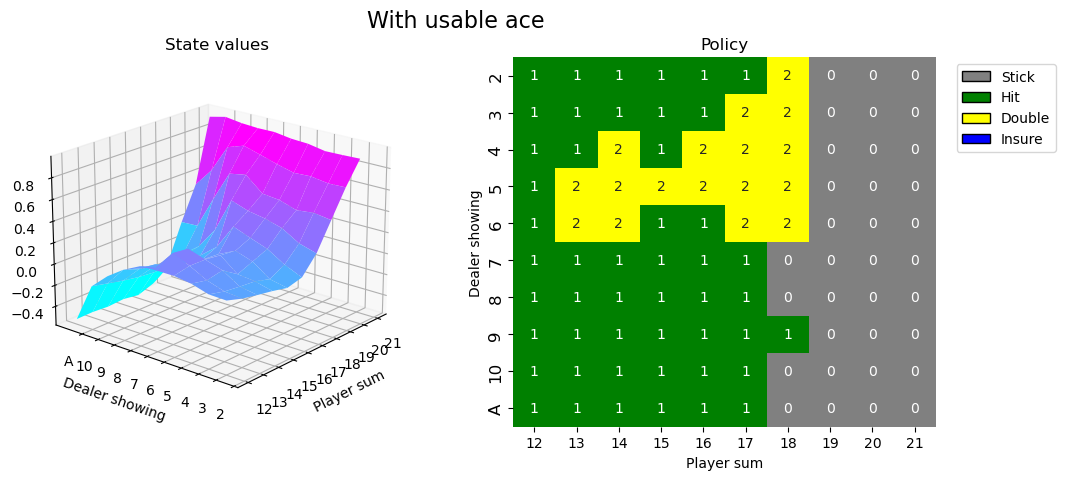

In [9]:
(Q_nt108, results_nt108, rewards_nt108, 
win_ratio_nt108, reward_ratio_nt108, 
net_gain_nt108, cumul_rewards_nt108, 
fig1_nt108, fig2_nt108) = wrapup(10**8, thorp = False, plot = True)

Now, the state-value function in Figure 3 looks much more smooth. It is evident that states where the dealer holds an ace are less valuable to the player, which is not surprising.

As compared to Figure 1, we can note that the states where the player holds a value of 9 to 11 have a higher value in Figure 3. This is due to the fact that we have implemented the doubling action; by doubling, the player will achieve a greater reward.

The resulting policy is mostly consistent with the earlier mentioned [blackjack strategy tables](https://www.blackjackapprenticeship.com/blackjack-strategy-charts/), although we have not included splits. The policies in some states, however, are not entirely comprehensible. For example, doubling on player hand 11 when the dealer holds a 10 or an ace, but not on dealer hand 9, does not make complete sense and is not consistent with the basic strategy. Perhaps this is something that would have changed, had we trained the agent even more.

It is worth mentioning that insurance is never included in the policy, which is consistent with virtually all recommendations for playing blackjack optimally. An exception to this rule is when the player is counting cards, as we shall see in the upcoming section.

Next, we evaluate how the derived optimal policy works by applying it in a "live" playing setting, using one million episodes. We do this for various amounts of training.

That is, we first train the agent using 10 000 episodes, then take the derived policy and apply it in a simulated game setting for one million games. We then calculate the win ratio and, given that we have included the doubling action, the reward-to-loss ratio and net gain counted in betting units. Then we proceed to do the same thing but after having trained the agent for 100 000 episodes, and so on.

#### Table 1: Strategy performance, one deck, n = 10^6 live episodes {-}

In [10]:
nocount_table = [["10^4", win_ratio_nt104, reward_ratio_nt104, net_gain_nt104], 
                 ["10^5", win_ratio_nt105, reward_ratio_nt105, net_gain_nt105],
                 ["10^6", win_ratio_nt106, reward_ratio_nt106, net_gain_nt106],
                 ["10^7", win_ratio_nt107, reward_ratio_nt107, net_gain_nt107],
                 ["10^8", win_ratio_nt108, reward_ratio_nt108, net_gain_nt108]]

df_nocount = pd.DataFrame(nocount_table, 
                          columns = ['Training episodes', 'Win/episodes', 
                                     'Rewards/losses', 'Net gain'], 
                          index=['', '', '', '', ''])
print(df_nocount)

 Training episodes  Win/episodes  Rewards/losses  Net gain
              10^4         0.425           0.890    -64236
              10^5         0.425           0.908    -52632
              10^6         0.435           0.977    -12075
              10^7         0.434           0.985     -7560
              10^8         0.434           0.986     -7260


After around 10 million episodes, the optimal policy has converged at a win ratio of circa 43.5 percent, and a reward/loss ratio slightly below 99 percent. The win ratio is somewhat higher than [what is usually claimed](https://www.casinoguardian.co.uk/blackjack/blackjack-odds-probabilities/) for playing blackjack optimally, which is said to be 43.2-43.3 percent. As we shall see, this will change when the number of decks are increased.

In the next table, we take the optimal policy derived after 100 million training episodes and apply it to a live playing setting where the shoe contains 2-8 decks.

#### Table 2: Optimal strategy performance on larger shoes {-}

In [11]:
nocount_deck_table = [test_on_largerdeck(Q_nt108, n_decks = 2),
                      test_on_largerdeck(Q_nt108, n_decks = 4),
                      test_on_largerdeck(Q_nt108, n_decks = 6),
                      test_on_largerdeck(Q_nt108, n_decks = 8)]

df_nocount_deck = pd.DataFrame(nocount_deck_table, 
                          columns = ['Number of decks', 'Win/episodes', 
                                     'Rewards/losses', 'Net gain'], 
                          index = ['', '', '', ''])
print(df_nocount_deck)

  Number of decks  Win/episodes  Rewards/losses  Net gain
                2         0.434           0.984     -8446
                4         0.433           0.980    -10386
                6         0.432           0.978    -11149
                8         0.432           0.977    -11981


As is evident from Table 2, the player edge is decreased when the shoe contains more decks. This is, of course, a known fact in the casino business and many casinos nowadays have shoes consisting of 6-8 decks. For shoes of this size, the win ratio is now around 43.2 percent and the reward-to-loss ratio about 98 percent. It is not unlikely that the latter ratio would be slightly higher, had we also included splits in the game.

This gives the house a small, but consistent, edge against the player. One may ask if it is possible to push the odds only slightly in the players' favor, and thereby gaining an edge against the house? This question will be answered in the upcoming section.

$\pagebreak$

## Beating the Dealer: Counting Cards {-}

Our next step will be to try to teach the agent to beat the dealer. Given that blackjack is a common casino game, one may wonder if this is really possible to do – would the casino offer a game where they might lose money?

The short answer is yes. The longer answer is that it depends on the circumstances, in other words the environment, of the game.

To beat the dealer, we introduce *card counting*, as developed by the mathematician Edward O. Thorp in the 1950s and 60s.

The cards are counted in the following fashion, described by Thorp himself in [an article from 1980](https://www.edwardothorp.com/wp-content/uploads/2016/11/CountingEveryCardInTheDeck.pdf):

* The cards 3, 4, 5, 6 counts as +1
* The cards 2, 7, 8, 9 counts as +0
* The cards 10, J, K, D counts as -1
* Aces are counted separately.

As the cards are dealt throughout the game, the player keeps a *running count* when seeing each card. The running count is then adjusted depending on the number of decks in play, according to the formula for the *true count* $C = 52 \cdot (\text{running count})/N$ where $N$ is the total number of cards left in play. As earlier, we will use only one deck, but explore what happens when the shoe size is increased later on.

A key to succeeding with card counting is not only adjusting the playing strategy, but also the bet. And this is where the separate ace count becomes relevant. The bets are placed in units according to the formula $B = C + (A/N - 1/13) \cdot 64$, where $A$ is the number of aces remaining in the shoe.

Now, our agent may make decisions based not only on the hand values as in the former sections, but must also take into account: 1. The bet placed at the beginning of the game, 2. The current card count. Given that both the count and bet can vary quite much, it goes without saying that this may lead to a significantly more complicated state-action space, with several thousand state-action pairs. To make matters worse, some of these state pairs are quite uncommon, making it even harder to find the optimal action in such cases. The fact that the bets are changing may also lead to an increase in the variance of the rewards, which further complicates the learning.

In order to make the learning more effective, we consider the following setup: The state-action space is enlarged by including the true count in each state, so that the agent takes into account the current count when making strategy decisions during play. However, the bet level is set deterministically according to the formula for $B$ above, based on the count at the beginning of the episode. In practice, though, we implement the betting so that the effect of the bet is incurred as a factor *after* the game (episode) is finished, and saved to a separate reward dictionary. As such, the varying bets do not influence the state-space, the in-training rewards, or other training aspects of the agent during the episodes; the agent is taught by using the same base bet of 1 as in the former section.

Moreover, we limit the count so that it does not exceed 20 or go below -20. A consequence of this is that the bet is also limited, between 1 and 59 units. Nevertheless, the state-action space has grown considerably.

As before, we use a learning rate $\alpha$ of 0.001, no discounting with $\gamma = 1$, and a decaying epsilon rate during training.

We shall now look at what happens to the policy when the count is high (at level 10).

In [12]:
(Q_t104, results_t104, rewards_t104, 
win_ratio_t104, reward_ratio_t104, 
net_gain_t104, cumul_rewards_t104, 
fig1_t104, fig2_t104) = wrapup(10**4, thorp = True)

In [13]:
(Q_t105, results_t105, rewards_t105, 
win_ratio_t105, reward_ratio_t105, 
net_gain_t105, cumul_rewards_t105, 
fig1_t105, fig2_t105) = wrapup(10**5, thorp = True)

In [14]:
(Q_t106, results_t106, rewards_t106, 
win_ratio_t106, reward_ratio_t106, 
net_gain_t106, cumul_rewards_t106, 
fig1_t106, fig2_t106) = wrapup(10**6, thorp = True)

In [15]:
(Q_t107, results_t107, rewards_t107, 
win_ratio_t107, reward_ratio_t107, 
net_gain_t107, cumul_rewards_t107, 
fig1_t107, fig2_t107) = wrapup(10**7, thorp = True)

In [16]:
(Q_t108, results_t108, rewards_t108, 
win_ratio_t108, reward_ratio_t108, 
net_gain_t108, cumul_rewards_t108, 
fig1_t108, fig2_t108) = wrapup(10**8, thorp = True)

#### Figure 4: State values and policies, n = 10^8 iterations, count = 10 {-}

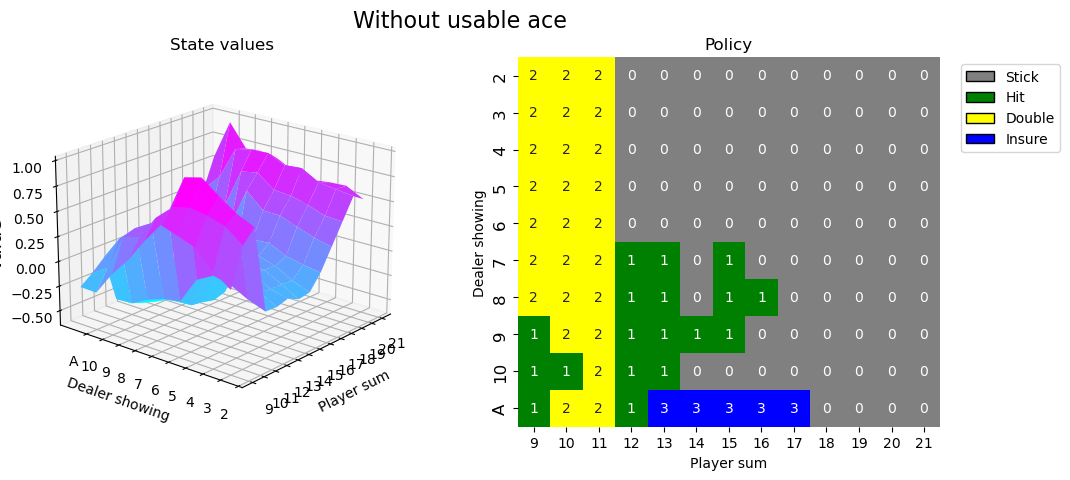

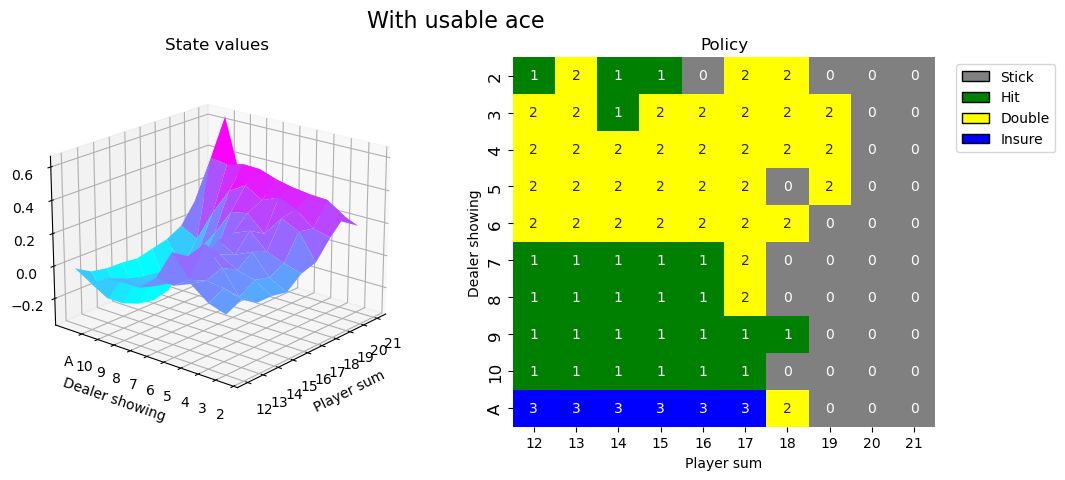

In [22]:
count_noace_valgrid, count_noace_polgrid = create_grids(Q_t108, "NUA", count_key = 10)
fig1 = create_plots(count_noace_polgrid, count_noace_valgrid, 
                    title = "Without usable ace")

count_ace_valgrid, count_ace_polgrid = create_grids(Q_t108, "UA", count_key = 10)
fig2 = create_plots(count_ace_polgrid, count_ace_valgrid, 
                    title = "With usable ace")

In Figure 4, it is apparent that the state-values for some hands are now higher than in any of the former plots, indicating a quite nice value for the player.

We can also note from the policy that insurance is, in fact, now profitable in some circumstances. This is not very surprising: If the count is high, the deck is rich in 10s, leading to the fact that there is a higher probability that the dealer holds a natural blackjack.

Like in the former section, we now evaluate how the derived optimal policy works by applying it in a live playing setting, using one million episodes. We again do this for various amounts of training.


$\pagebreak$

#### Table 3: Strategy performance, one deck, n = 10^6 live episodes {-}

In [23]:
count_table = [["10^4", win_ratio_t104, reward_ratio_t104, net_gain_t104], 
               ["10^5", win_ratio_t105, reward_ratio_t105, net_gain_t105],
               ["10^6", win_ratio_t106, reward_ratio_t106, net_gain_t106],
               ["10^7", win_ratio_t107, reward_ratio_t107, net_gain_t107],
               ["10^8", win_ratio_t108, reward_ratio_t108, net_gain_t108]]

df_count = pd.DataFrame(count_table, 
                          columns = ['Training episodes', 'Win/episodes', 
                                     'Rewards/losses', 'Net gain'], 
                          index=['', '', '', '', ''])
print(df_count)

 Training episodes  Win/episodes  Rewards/losses  Net gain
              10^4         0.392           0.771   -359771
              10^5         0.417           0.861   -208782
              10^6         0.430           0.953    -64918
              10^7         0.436           1.029     37344
              10^8         0.437           1.059     75073


As shown in Table 3, the reward/loss ratio is above one after 10 million training episodes. This means that the rewards are greater than the losses – the agent is actually beating the dealer! With more training, the edge is increased even further.

So, to conclude: By using card counting, we have now taught the agent how to beat the dealer. But these results are for one deck only, what happens if we increase the shoe size?

#### Table 4: Optimal strategy performance on larger shoes {-}

In [24]:
deck_table = [test_on_largerdeck(Q_t108, n_decks = 2, thorp = True),
              test_on_largerdeck(Q_t108, n_decks = 4, thorp = True),
              test_on_largerdeck(Q_t108, n_decks = 6, thorp = True),
              test_on_largerdeck(Q_t108, n_decks = 8, thorp = True)]

df_deck = pd.DataFrame(deck_table, 
                          columns = ["Number of decks", 'Win/episodes', 
                                     'Rewards/losses',  'Net gain'], 
                          index = ['', '', '', ''])
print(df_deck)

  Number of decks  Win/episodes  Rewards/losses  Net gain
                2         0.435           1.019     19035
                4         0.432           0.999      -720
                6         0.432           0.993     -4904
                8         0.433           0.992     -5793


As before, Table 4 displays the fact that the player edge is decreased when more decks are in play. The reward ratio is still above one when there are two decks in the shoe, but then falls behind.

As mentioned before, many casinos nowadays use 6-8 decks. It's certainly not impossible that the reward-to-loss ratio would be slightly above one even in such cases, if we had included splits in the game and trained the agent even further. However, the edge would likely be quite small.

Many casinos employ countermeasures against card counters. Increasing the shoe size is just one of those. Statistical software to detect card counting, and throw such players off the table, are another possibility. There are also many variations to blackjack rules, which might give the house further edge against the player.

## Concluding remarks and discusson {-}

In this project we have shown that it is possible, by Q-learning, to teach an agent how to 1. Play blackjack in a manner close to the optimal "basic strategy", 2. Beat the dealer through card counting.

The advantages of both the optimal basic strategy and card counting, however, diminishes as the shoe size is increased. Many casinos also employ other techniques as countermeasures, and use statistical software to detect when a player is counting cards. As such, the practical usefulness of the card counting results here may be limited.

To further the analysis, a natural next step would be to include the possibility of splitting hands during play, and training the agent even more.

$\pagebreak$

## References {-}

* [Wikipedia, Blackjack](https://en.wikipedia.org/wiki/Blackjack)

* [Sutton and Barto, Reinforcement Learning: An introduction](http://incompleteideas.net/book/the-book-2nd.html)

* [Solving Blackjack with Q-Learning, Gym documentation](https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/)

* [Github: Rianrajegende](https://github.com/rianrajagede/reinforcement-learning/blob/master/BlackJack_TD.py)

* [Thorp, The Mathematics of Gambling](https://www.edwardothorp.com/wp-content/uploads/2016/11/CountingEveryCardInTheDeck.pdf)

* [Blackjack Strategy Charts](https://www.blackjackapprenticeship.com/blackjack-strategy-charts/)

* [Blackjack Odds and Probabilities](https://www.casinoguardian.co.uk/blackjack/blackjack-odds-probabilities/)